**AI-Powered Antiviral Compound Screening Platform**

Target: SARS-CoV-2 Main Protease (Mpro)

In [2]:
# install RDKIT
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 37.1 MB/s eta 0:00:00


In [3]:
# Import libraries
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [4]:
# Silence RDKit warnings
RDLogger.DisableLog('rdApp.*')

[INFO] Loading sample molecular data...
[INFO] Featurizing molecules...
[INFO] Training deep learning model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[INFO] Simulating docking scores...

[RESULT] Top Candidates Ranked:
                         SMILES  DL_Probability  Docking_Score  \
0  CCN(CC)CCOC(=O)C1=CC=CC=C1Cl        0.997625      -9.252304   
1      CC(C)NCC(O)COC1=CC=CC=C1        0.274703      -6.289904   

   Composite_Score  
0         9.230326  
1         1.727858  


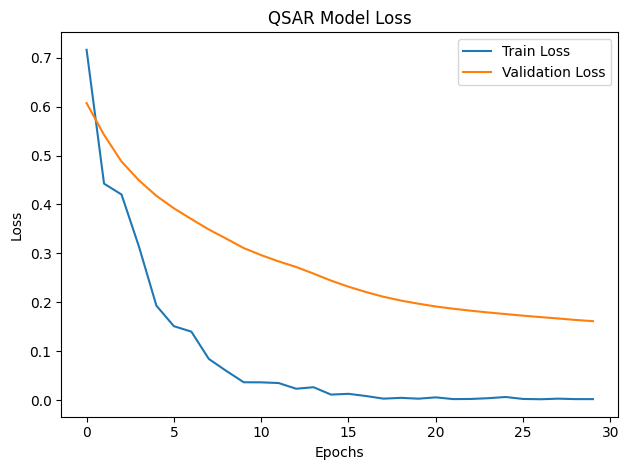

In [16]:
# Main Pipeline
def main():
    print("[INFO] Loading sample molecular data...")

    smiles_data = [
        ('CC(C)CC1=CC=C(C=C1)C(C)C(=O)O', 1),  # Ibuprofen (active)
        ('CC(=O)OC1=CC=CC=C1C(=O)O', 0),       # Aspirin (inactive)
        ('C1=CC=C(C=C1)C=O', 0),               # Benzaldehyde
        ('CCOC(=O)C1=CC=CC=C1Cl', 1),          # Clofibrate
        ('CC1=C(C(=CC=C1)O)C(=O)O', 1),        # Salicylic acid
        ('CN1CCCC1=O', 0),                     # Pyrrolidone
        ('CNC1=CC=C(C=C1)O', 1),               # Paracetamol (active)
        ('COC1=CC=CC=C1OC', 0),                # Dimethoxybenzene
        ('CCN(CC)CCOC(=O)C1=CC=CC=C1Cl', 1),   # Lidocaine
        ('CC(C)NCC(O)COC1=CC=CC=C1', 1),       # Propranolol
    ]

    # Step 1: Featurization
    print("[INFO] Featurizing molecules...")
    X, y = featurize(smiles_data)

    # Step 2: Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 3: Train Deep Learning QSAR Model
    print("[INFO] Training deep learning model...")
    model = build_qsar_model(X.shape[1])
    history = model.fit(X_train_scaled, y_train,
                        epochs=30,
                        batch_size=4,
                        verbose=0,
                        validation_data=(X_test_scaled, y_test))

    # Step 4: Predict activity
    pred_probs = model.predict(X_test_scaled).flatten()
    pred_labels = (pred_probs > 0.5).astype(int)

    # Step 5: Mock docking scores (simulate AutoDock/Vina output)
    print("[INFO] Simulating docking scores...")
    docking_scores = np.random.uniform(-11, -6, size=len(pred_probs))  # lower = better

    # Step 6: Combine QSAR + Docking for final score
    ranking_df = pd.DataFrame({
        'SMILES': [smiles_data[i][0] for i in range(len(y))][-len(pred_probs):],
        'DL_Probability': pred_probs,
        'Docking_Score': docking_scores
    })
    ranking_df['Composite_Score'] = ranking_df['DL_Probability'] * (-ranking_df['Docking_Score'])
    ranking_df.sort_values(by='Composite_Score', ascending=False, inplace=True)

    print("\n[RESULT] Top Candidates Ranked:")
    print(ranking_df[['SMILES', 'DL_Probability', 'Docking_Score', 'Composite_Score']].head(5))

    # Step 7: Plot training performance
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("QSAR Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig("qsar_training_loss.png")
    plt.show()


if __name__ == "__main__":
    main()